# COMP47670 - Assignment 2 - Text Classification
**Student Name: Meleesha Mayola Dsouza, Nikil Mohan**<br>
**Student Number: 18200024, 18200037**

In [60]:
# Import the required libraries
import os
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC  
from sklearn.metrics import *
%matplotlib inline

## Task 1: Selecting the review categories and scraping the data from the website

We will be performing the following steps under Task 1:<br/>
Step 1: Choosing the review categories. We have chosen the following 
    <br/>&emsp;&emsp;&emsp;&emsp;_Health and Medical_
    <br/>&emsp;&emsp;&emsp;&emsp;_Automotive_<br/>
Step 2: Scraping the user reviews from the websites using the python package Beautiful Soup<br/>
Step 3: Assigning class labels as 'positive' or 'negative' based on the user provided star ratings<br/>
Step 4: Storing the user reviews in separate csv files for different review categories<br/>
Step 5: Importing from the csv files to dataframe for easy data science manipulations

In [2]:
# For specifying the website, we append the individual webpages to the base website URL
endpoint = 'http://mlg.ucd.ie/modules/yalp/'
# The categories chosen have been represented in the form of a list
categories = ['health_medical_list', 'automotive_list.html']

# The extract_page function is created to extract the overall data present in the webpage
def extract_page(url):
    response = requests.get(url)
    data = response.text
    # We use the BeautifulSoup package to parse the data that is collected for webscraping
    soup = BeautifulSoup(data,'html.parser')
    return soup

# The extract_reviews function is created to extract the reviews from the webpoge
def extract_reviews(url):
    soup = extract_page(url)
    # We use the 'div' as the identifier as all the reviews are present within this tag
    reviews_block = soup.findAll("div", { "class" : "review" })
    # We create a list called review_list to store all the reviews that are present in the category
    review_list =[]
    for reviews in reviews_block:
        review = {}
        # We use the 'img' as the identifier as all the ratings are present within this tag
        star = reviews.find('img')
        review["comments"] = reviews.find("p", { "class" : "text" }).get_text()
        # We use the 'alt' attribute as the identifier as the rating present in this attribute can be easily obtained
        # We use the concept of any rating having a value of 4 or 5 as Positive
        # We use the concept of any rating having a value of 1, 2 or 3 as Negative
        review["rating"] = 'positive' if int(star.get('alt').split('-')[0]) >= 4 else 'negative'
        review_list.append(review)        
    return review_list

# The extract_data function is created to extract the data from each of the review links
# This function in turn calls the extract_page and the extract_reviews
def extract_data(url):
    soup = extract_page(url)
    links = soup.find_all('a')
    review_list =[]
    for link in links:
        # We identify the links of each of the reviews by extracting the values present in the href attribute
        url = endpoint + link.get('href')
        review = extract_reviews(url)
        # We concatenate the reviews from all the links
        review_list = review_list+review
    return review_list

# The create_database function is created to write the reviews and ratings to csv files for easier processing
# The function will be called each time for each category
def create_database(category_name, reviews):
    header = reviews[0].keys()
    with open(category_name, 'w',newline='', encoding="utf-8") as output_file:
        dict_writer = csv.DictWriter(output_file, header)
        dict_writer.writeheader()
        dict_writer.writerows(reviews)

We create a database for Health and Medical reviews so that we can process them.

In [3]:
# We access the page for the reviews of the category 'Health and Medical'
# We scrape the data using the functions defined by us
# This data is stored in separate files in the csv format
url = endpoint + categories[0]
review_list = extract_data(url)
create_database('Health_Medical.csv', review_list)

We create a database for Automotive reviews so that we can process them.

In [4]:
# We access the page for the reviews of the category 'Automotive'
# We scrape the data using the functions defined by us
# This data is stored in separate files in the csv format
url = endpoint + categories[1]
review_list = extract_data(url)
create_database('Automotive.csv', review_list)

In [5]:
# The dataframe dataset_A has the data obtained from csv containing Health and Medical reviews
dataset_A = pd.read_csv('Health_Medical.csv')
# We check the dimensions of the Health and Medical review data that we have
print('Dimensions of the Health and Medical dataset: '+str(dataset_A.shape))
print('\n')
# We also check the count of reviews in the Health and Medical dataset for each label, i.e. postive or negative
print(dataset_A.groupby('rating')['rating'].count())
# A preview of the data is shown
dataset_A.head()

Dimensions of the Health and Medical dataset: (1450, 2)


rating
negative     407
positive    1043
Name: rating, dtype: int64


,comments,rating
0,I have so many good things to say about this p...,positive
1,I found them to be highly skilled and an exper...,positive
2,Where do I even begin? This office has been so...,positive
3,I went in because I had toothache and needed a...,positive
4,Found a new dental office. This place is amazi...,positive


In [6]:
# The dataframe dataset_B has the data obtained from csv containing Automotive reviews
dataset_B = pd.read_csv('Automotive.csv')
# We check the dimensions of the Automotive review data that we have
print('Dimensions of the Automotive dataset: '+str(dataset_B.shape))
print('\n')
# We also check the count of reviews in the Automotive dataset for each label, i.e. postive or negative
print(dataset_B.groupby('rating')['rating'].count())
# A preview of the data is shown
dataset_B.head()

Dimensions of the Automotive dataset: (1455, 2)


rating
negative    482
positive    973
Name: rating, dtype: int64


,comments,rating
0,I arrived at 3 PM and the dealership closed at...,positive
1,I dropped my car off on a Wednesday morning fo...,negative
2,My parents have been buying cars off of Donna ...,positive
3,I recently bought another car from Donna Dunni...,positive
4,I had to schedule an appointment due to the ai...,positive


## Task 2: Applying the pre-processing steps and building the classifier model

To perform the preprocessing steps, we have used nltk packages. Some of the preprocessing steps done are as follows
<br/>&emsp;&emsp;&emsp;&emsp;Tokenization
<br/>&emsp;&emsp;&emsp;&emsp;Removal of punctuations
<br/>&emsp;&emsp;&emsp;&emsp;Conversion to lower case
<br/>&emsp;&emsp;&emsp;&emsp;Removal of stop words
<br/><br/>

We then use this preprocessed data to build the classifier models. We build a different classifier for each category of reviews to classify the positive and negative reviews. After building this classifier, we use an evaluation stategy to test the predictions for each of the classifiers. The evaluation strategy used in this assignment is the 10-fold cross-validation.

In [7]:
# The preprocess_text function is called to handle the preprocessing steps for each review individually
def preprocess_text(text):
    # The data that is passed as the input is first converted to lowercase to standardize it
    # We then tokenize this data into individual tokens
    tokenized_words = word_tokenize(text.lower())
    # We remove the words which are not alpha-numeric like punctuations
    normalised_words = [word for word in tokenized_words if word.isalnum()]
    # We remove the stopwords in the corpus like 'is', 'an', etc. as they do not contribute to the efficiency of the classifier
    filtered_words = [word for word in normalised_words if word.lower() not in stopwords.words('english')]
    # we use a lemmatizer to reduce the inflected words to its lemma so that the classifer can identify them as a single word
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # we use stemmer to words to its stem
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in lemmatized_words]
    return ' '.join(stemmed_words)

# The preprocess_reviews function is used to handle the pre-processing of all the reviews in the webpage
# In turn, it calls the preprocess_text function to pre-process the reviews one by one
def preprocess_reviews(dataset):
    for indx, comments in enumerate(dataset['comments']):
        dataset['comments'][indx] = preprocess_text(comments)

In [8]:
# We perform all the preprocessing steps on the reviews of the Health and Medical reviews
preprocess_reviews(dataset_A)
# We have displayed a few of the entries to show the difference between the data after preprocessing
# The data before preprocessing for the Health and Medical datatset has already been displayed previously
dataset_A.head()

,comments,rating
0,mani good thing say place need clean fill deci...,positive
1,found highli skill experienc dentistri will wo...,positive
2,even begin offic incred good famili love staff...,positive
3,went toothach need clean realli friendli promp...,positive
4,found new dental offic place amaz peopl work p...,positive


In [9]:
# We perform all the preprocessing steps on the reviews of the Automotive reviews
preprocess_reviews(dataset_B)
# We have displayed a few of the entries to show the difference between the data after preprocessing
# The data before preprocessing for the Automotive dataset has already been displayed previously
dataset_B.head()

,comments,rating
0,arriv 3 pm dealership close 6 thought left ple...,positive
1,drop car wednesday morn diagnost john salmon t...,negative
2,parent buy car donna dunnivan decad alway sati...,positive
3,recent bought anoth car donna dunnivan 1 cochr...,positive
4,schedul appoint due airbag recal use websit st...,positive


### Merging the dataset as a preprocessing step to build the classifier

We first merge the data from the dataset of two categrories so that we can apply the feature engineering steps required to process the data.

In [10]:
# Merging the two datasets to form a unified dataset
merged_dataset = pd.concat([dataset_A,dataset_B])
# Numeric representation of the dataset using tfidf vector
tfidf_vectorizer = TfidfVectorizer()
X_merged = tfidf_vectorizer.fit_transform(merged_dataset['comments'])
# We set the target value for the classifier
y_merged = merged_dataset['rating']
X_merged.shape

(2905, 8631)

In [11]:
X_reviewSize_A=dataset_A.shape[0]
X_reviewSize_B=dataset_B.shape[0]
# Identifying the boundary of each review category to help split later
print(X_reviewSize_A)
print(X_reviewSize_B)

1450
1455


We now split the data to the values corresponding to its review categories.

In [12]:
X_A = X_merged[:X_reviewSize_A]
target_A = y_merged[:X_reviewSize_A]
X_B = X_merged[X_reviewSize_A:]
target_B = y_merged[X_reviewSize_A:]
# Identifying the dimensions of the separated datasets
print(X_A.shape)
print(X_B.shape)

(1450, 8631)
(1455, 8631)


### Building the classifier for the Health and Medical Review data

We first apply standard text pre-processing steps to generate the document-term matrix for the reviews of Health and Medical category.

In [13]:
# We partition the data to use for the classifier. We use a split of 70% training and 30% test data
data_A_train, data_A_test, target_A_train, target_A_test = train_test_split(X_A, target_A, test_size=0.3)
print("The training set for Health and Medical reviews has %d examples" % data_A_train.shape[0] )
print("The test set for Health and Medical reviews has %d examples" % data_A_test.shape[0] )

The training set for Health and Medical reviews has 1015 examples
The test set for Health and Medical reviews has 435 examples


#### Experimenting with the Logistic Regression classifier.

In [14]:
# For the purpose of classification for the Health and Medical reviews, we experiment using Logistic Regression
model_A_logreg = linear_model.LogisticRegression(solver='liblinear')
model_A_logreg.fit(data_A_train, target_A_train)
print(model_A_logreg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


In [15]:
# After training the model, we perform the actual prediction
predicted_A_logreg = model_A_logreg.predict(data_A_test)
# We build a confusion matrix so that we can see the classifiers performancee
cm_A_logreg = confusion_matrix(target_A_test, predicted_A_logreg,labels=['positive','negative'])
print(cm_A_logreg)

[[312   1]
 [ 62  60]]


In [16]:
# We use metrics to check the performance of the Logistic regression clasifier on the Health and Medical review data
CategoryA_accuracy_LogReg = accuracy_score(target_A_test, predicted_A_logreg)
print("Accuracy of the Logistic Regression classifier = %.2f" % CategoryA_accuracy_LogReg )
# We indicate that we are interested in the Positive class here, which is labelled as "positive"
print("Precision (Positive) = %.2f" % precision_score(target_A_test, predicted_A_logreg, pos_label='positive') )
print("Recall (Positive) = %.2f" % recall_score(target_A_test, predicted_A_logreg, pos_label='positive') )
print("F1 (Positive) = %.2f" % f1_score(target_A_test, predicted_A_logreg, pos_label='positive') )

Accuracy of the Logistic Regression classifier = 0.86
Precision (Positive) = 0.83
Recall (Positive) = 1.00
F1 (Positive) = 0.91


In [17]:
# A summary of the statistics is generated using scikit-learn's built in methods
print(classification_report(target_A_test, predicted_A_logreg, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.98      0.49      0.66       122
    positive       0.83      1.00      0.91       313

   micro avg       0.86      0.86      0.86       435
   macro avg       0.91      0.74      0.78       435
weighted avg       0.88      0.86      0.84       435



A better evaluation mechanism would be to use the k-fold cross-validation approach. In the standard split, we are ignoring a part of the dataset. In this cross validation process, every portion of the data has the ability to be part of the training set at one point. Below, we have used a 10-fold cross validation method.

In [18]:
# Cross validation using 10 fold for the Logistic Regression approach used for classifying Health and Medical reviews
acc_scores_A_logreg =  cross_val_score(model_A_logreg, X_A, target_A, cv=10, scoring="accuracy")
print("Logistic Regression classifier for Health and Medical reviews: Mean cross-validation accuracy = %.2f" % acc_scores_A_logreg.mean() )

Logistic Regression classifier for Health and Medical reviews: Mean cross-validation accuracy = 0.87


#### Experimenting with the Naive Bayes classifier.

In [19]:
# For the purpose of classification for the Health and Medical reviews, we experiment using Naive Bayes
model_A_nb = MultinomialNB().fit(data_A_train, target_A_train)
print(model_A_nb)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [20]:
# After training the model, we perform the actual prediction
predicted_A_nb = model_A_nb.predict(data_A_test)
# We build a confusion matrix so that we can see the classifiers performancee
cm_A_nb = confusion_matrix(target_A_test, predicted_A_nb,labels=['positive','negative'])
print(cm_A_nb)

[[312   1]
 [118   4]]


In [21]:
# We use metrics to check the performance of the Naive Bayes clasifier on the Health and Medical review data
CategoryA_accuracy_nb = accuracy_score(target_A_test, predicted_A_nb)
print("Accuracy of the Naive Bayes classifier = %.2f" % CategoryA_accuracy_nb )
# We indicate that we are interested in the Positive class here, which is labelled as "positive"
print("Precision (Positive) = %.2f" % precision_score(target_A_test, predicted_A_nb, pos_label='positive') )
print("Recall (Positive) = %.2f" % recall_score(target_A_test, predicted_A_nb, pos_label='positive') )
print("F1 (Positive) = %.2f" % f1_score(target_A_test, predicted_A_nb, pos_label='positive') )

Accuracy of the Naive Bayes classifier = 0.73
Precision (Positive) = 0.73
Recall (Positive) = 1.00
F1 (Positive) = 0.84


In [22]:
# A summary of the statistics is generated using scikit-learn's built in methods
print(classification_report(target_A_test, predicted_A_nb, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.80      0.03      0.06       122
    positive       0.73      1.00      0.84       313

   micro avg       0.73      0.73      0.73       435
   macro avg       0.76      0.51      0.45       435
weighted avg       0.75      0.73      0.62       435



A better evaluation mechanism would be to use the k-fold cross-validation approach. In the standard split, we are ignoring a part of the dataset. In this cross validation process, every portion of the data has the ability to be part of the training set at one point. Below, we have used a 10-fold cross validation method.

In [23]:
# Cross validation using 10 fold for the Naive Bayes approach used for classifying Health and Medical reviews
acc_scores_A_nb =  cross_val_score(model_A_nb, X_A, target_A, cv=10, scoring="accuracy")
print("Naive Bayes classifier for Health and Medical reviews: Mean cross-validation accuracy = %.2f" % acc_scores_A_nb.mean() )

Naive Bayes classifier for Health and Medical reviews: Mean cross-validation accuracy = 0.73


From the experiments performed on the Health and Medical review data, we can see that the Logistic Regression and Naive Bayes classifier produces similar results.
Due to the slight increase in accuracy of the Logistic Regression Model, we choose this model for evaluation in task 3.

### Building the classifier for the Automotive Review data

We apply standard text pre-processing steps to generate the document-term matrix for the reviews of Automotive category.

In [24]:
# We partition the data to use for the classifier. We use a split of 70% training and 30% test data
data_B_train, data_B_test, target_B_train, target_B_test = train_test_split(X_B, target_B, test_size=0.3)
print("The training set for Automotive reviews has %d examples" % data_B_train.shape[0] )
print("The test set for Automotive reviews has %d examples" % data_B_test.shape[0] )

The training set for Automotive reviews has 1018 examples
The test set for Automotive reviews has 437 examples


 #### Experimenting with the K-Nearest Neighbor (KNN) classifier.

In [25]:
# For the purpose of classification for the Automotive reviews, we use KNN where n=3
model_B_knn = KNeighborsClassifier(n_neighbors=3)
model_B_knn.fit(data_B_train, target_B_train)
print(model_B_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')


In [26]:
# After training the model, we perform the actual prediction
predicted_B_knn = model_B_knn.predict(data_B_test)
# We build a confusion matrix so that we can see the classifiers performancee
cm_B_knn = confusion_matrix(target_B_test, predicted_B_knn,labels=['positive','negative'])
print(cm_B_knn)

[[258  32]
 [ 58  89]]


In [27]:
# We use metrics to check the performance of the KNN clasifier on the Automotive review data
CategoryB_accuracy_KNN = accuracy_score(target_B_test, predicted_B_knn)
print("Accuracy of the KNN classifier = %.2f" % CategoryB_accuracy_KNN )
# We indicate that we are interested in the Positive class here, which is labelled as "positive"
print("Precision (Positive) = %.2f" % precision_score(target_B_test, predicted_B_knn, pos_label='positive') )
print("Recall (Positive) = %.2f" % recall_score(target_B_test, predicted_B_knn, pos_label='positive') )
print("F1 (Positive) = %.2f" % f1_score(target_B_test, predicted_B_knn, pos_label='positive') )

Accuracy of the KNN classifier = 0.79
Precision (Positive) = 0.82
Recall (Positive) = 0.89
F1 (Positive) = 0.85


In [28]:
# A summary of the statistics is generated using scikit-learn's built in methods
print(classification_report(target_B_test, predicted_B_knn, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.74      0.61      0.66       147
    positive       0.82      0.89      0.85       290

   micro avg       0.79      0.79      0.79       437
   macro avg       0.78      0.75      0.76       437
weighted avg       0.79      0.79      0.79       437



A better evaluation mechanism would be to use the k-fold cross-validation approach. In the standard split, we are ignoring a part of the dataset. In this cross validation process, every portion of the data has the ability to be part of the training set at one point. Below, we have used a 10-fold cross validation method.

In [29]:
# Cross validation using 10 fold for the KNN approach used for classifying Automotive reviews
acc_scores_B_knn =  cross_val_score(model_B_knn, X_B, target_B, cv=10, scoring="accuracy")
print("KNN classifier for Automotive reviews: Mean cross-validation accuracy = %.2f" % acc_scores_B_knn.mean() )

KNN classifier for Automotive reviews: Mean cross-validation accuracy = 0.69


 #### Experimenting with the Support Vector Machine (SVM) classifier.

In [30]:
# For the purpose of classification for the Automotive reviews, we use SVC
model_B_svc = SVC(gamma='auto',kernel='linear')
model_B_svc.fit(data_B_train, target_B_train)
print(model_B_svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [31]:
# After training the model, we perform the actual prediction
predicted_B_svc = model_B_svc.predict(data_B_test)
# We build a confusion matrix so that we can see the classifiers performancee
cm_B_svc = confusion_matrix(target_B_test, predicted_B_svc,labels=['positive','negative'])
print(cm_B_svc)

[[278  12]
 [ 27 120]]


In [32]:
# We use metrics to check the performance of the SVC clasifier on the Automotive review data
CategoryB_accuracy_svc = accuracy_score(target_B_test, predicted_B_svc)
print("Accuracy of the SVC classifier = %.2f" % CategoryB_accuracy_svc )
# We indicate that we are interested in the Positive class here, which is labelled as "positive"
print("Precision (Positive) = %.2f" % precision_score(target_B_test, predicted_B_svc, pos_label='positive') )
print("Recall (Positive) = %.2f" % recall_score(target_B_test, predicted_B_svc, pos_label='positive') )
print("F1 (Positive) = %.2f" % f1_score(target_B_test, predicted_B_svc, pos_label='positive') )

Accuracy of the SVC classifier = 0.91
Precision (Positive) = 0.91
Recall (Positive) = 0.96
F1 (Positive) = 0.93


In [33]:
# A summary of the statistics is generated using scikit-learn's built in methods
print(classification_report(target_B_test, predicted_B_svc, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.91      0.82      0.86       147
    positive       0.91      0.96      0.93       290

   micro avg       0.91      0.91      0.91       437
   macro avg       0.91      0.89      0.90       437
weighted avg       0.91      0.91      0.91       437



A better evaluation mechanism would be to use the k-fold cross-validation approach. In the standard split, we are ignoring a part of the dataset. In this cross validation process, every portion of the data has the ability to be part of the training set at one point. Below, we have used a 10-fold cross validation method.

In [34]:
# Cross validation using 10 fold for the SVC approach used for classifying Automotive reviews
acc_scores_B_svc =  cross_val_score(model_B_svc, X_B, target_B, cv=10, scoring="accuracy")
print("SVC classifier for Automotive reviews: Mean cross-validation accuracy = %.2f" % acc_scores_B_svc.mean() )

SVC classifier for Automotive reviews: Mean cross-validation accuracy = 0.88


From the experiments performed on the Automotive review data, we can see that the KNN and SVM classifier produced different results.
Due to the drastic increase in accuracy of the SVM Model, we choose this model for evaluation in task 3.

In [105]:
Individual_Accuracy_results = [acc_scores_A_logreg.mean(), acc_scores_A_nb.mean(),acc_scores_B_knn.mean(),acc_scores_B_svc.mean()]

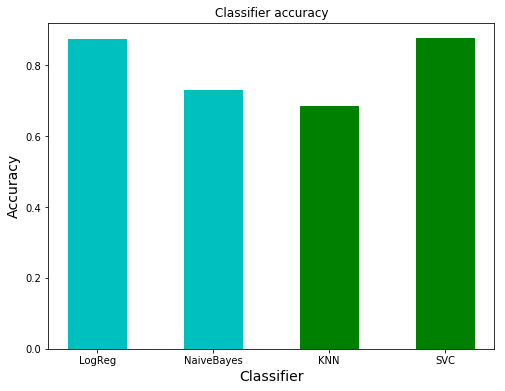

In [106]:
# We plot the graph to show the difference in accuracies of each of the classifiers
index = np.arange(len(Individual_Accuracy_results))
plt.figure(figsize=(8,6))
barlist = plt.bar(index, Individual_Accuracy_results, width=0.5)
# Two colours are used to represent the bars because each colour represents the category on which the classifer was trained on
barlist[0].set_color('c')
barlist[1].set_color('c')
barlist[2].set_color('g')
barlist[3].set_color('g')
plt.xlabel('Classifier',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.xticks(index, ["LogReg","NaiveBayes","KNN","SVC"])
plt.title('Classifier accuracy')
plt.show()

The Logistic Regression and Naive Bayes classifier models were used on the Health and Medical Review dataset.<br/>
The KNN and the SVC classifier models were used on the Automotive Review dataset.<br/>
We choose the classifiers based on the accuracy obtained using the 10 fold cross validation technique.<br/>
From the graph, it can be seen that the final classifiers chosen for Task 3 should be Logistic Regression and the SVM classifier for the respective categories.

## Task 3: Performance of classification models across categories

In this section, we will use the classification model trained on the training data from one category to test it with the test data from the same category, as well as, test it with the entire data from the other category.<br/>We have already trained two different classifiers on the two categories of reviews chosen. The two classifiers used in the previous task will be used to check the performance across categories.

For the Health and Medical review category, we chose Logistic Regression Classifier with a train-test split of 30% as test data.

In [90]:
print('Using the Logistic Regression classifier model on the test data of the Health and Medical Category, we have an accuracy of %.2f' % CategoryA_accuracy_LogReg)

Using the Logistic Regression classifier model on the test data of the Health and Medical Category, we have an accuracy of 0.86


We will now use this Logistic Regression classifier model to test the data of the Automotive review Category

In [91]:
# After training the model on Health and Medical reviews, we perform the prediction on Automotive reviews
Prediction_diff_LogReg = model_A_logreg.predict(X_B)
# We build a confusion matrix so that we can see the classifiers performancee
cm_diff_logreg = confusion_matrix(target_B, Prediction_diff_LogReg,labels=['positive','negative'])
print(cm_diff_logreg)

[[958  15]
 [262 220]]


In [92]:
# We use metrics to check the performance of the Logistic regression clasifier on the Automotive data
accuracy_diff_LogReg = accuracy_score(target_B, Prediction_diff_LogReg)
print("Accuracy of the Logistic Regression classifier = %.2f" % accuracy_diff_LogReg )
# We indicate that we are interested in the Positive class here, which is labelled as "positive"
print("Precision (Positive) = %.2f" % precision_score(target_B, Prediction_diff_LogReg, pos_label='positive') )
print("Recall (Positive) = %.2f" % recall_score(target_B, Prediction_diff_LogReg, pos_label='positive') )
print("F1 (Positive) = %.2f" % f1_score(target_B, Prediction_diff_LogReg, pos_label='positive') )

Accuracy of the Logistic Regression classifier = 0.81
Precision (Positive) = 0.79
Recall (Positive) = 0.98
F1 (Positive) = 0.87


For the Automotive review category, we chose SVC Classifier and a train-test split of 30% as test data.

In [99]:
print('Using the SVC classifier model on the test data of the Automotive Category, we have an accuracy of %.2f' % CategoryB_accuracy_svc)

Using the SVC classifier model on the test data of the Automotive Category, we have an accuracy of 0.91


We will now use this SVC classifier model to test the data of the Health and Medical review Category

In [94]:
# After training the model on Autmotive reviews, we perform the actual prediction on the Health and Medical reviews
Prediction_diff_svc = model_B_svc.predict(X_A)
# We build a confusion matrix so that we can see the classifiers performancee
cm_diff_svc = confusion_matrix(target_A, Prediction_diff_svc,labels=['positive','negative'])
print(cm_diff_svc)

[[990  53]
 [ 79 328]]


In [95]:
# We use metrics to check the performance of the SVC clasifier on the Health and Medical data
accuracy_diff_svc = accuracy_score(target_A, Prediction_diff_svc)
print("Accuracy of the SVC classifier = %.2f" % accuracy_diff_svc )
# We indicate that we are interested in the Positive class here, which is labelled as "positive"
print("Precision (Positive) = %.2f" % precision_score(target_A, Prediction_diff_svc, pos_label='positive') )
print("Recall (Positive) = %.2f" % recall_score(target_A, Prediction_diff_svc, pos_label='positive') )
print("F1 (Positive) = %.2f" % f1_score(target_A, Prediction_diff_svc, pos_label='positive') )

Accuracy of the SVC classifier = 0.91
Precision (Positive) = 0.93
Recall (Positive) = 0.95
F1 (Positive) = 0.94


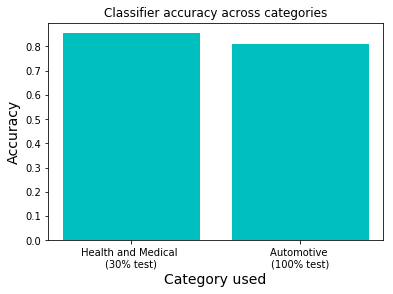

In [116]:
# We use accuracies from the simple hold out approach for the comparison
LogReg_Accuracies=[CategoryA_accuracy_LogReg,accuracy_diff_LogReg]
# We plot the graph to show the difference in accuracies of the LogReg classifier across categories
index = np.arange(len(LogReg_Accuracies))
barlist = plt.bar(index, LogReg_Accuracies)
barlist[0].set_color('c')
barlist[1].set_color('c')
plt.xlabel('Category used',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.xticks(index, ["Health and Medical \n(30% test)","Automotive \n(100% test)"])
plt.title('Classifier accuracy across categories')
plt.show()

In [103]:
print("Summary of results when the classifier used was Logistic Regression:-")
print("\nAccuracy when Training data and Test data are both on Health and Medical Review = %.2f" % CategoryA_accuracy_LogReg)
print("\nAccuracy when Training data is Health and Medical review, but Test data is Automotive review= %.2f" % accuracy_diff_LogReg)

Summary of results when the classifier used was Logistic Regression:-

Accuracy when Training data and Test data are both on Health and Medical Review = 0.86

Accuracy when Training data is Health and Medical review, but Test data is Automotive review= 0.81


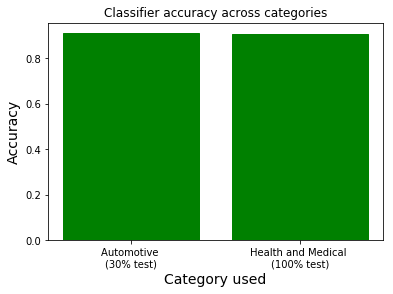

In [118]:
# We use accuracies from the simple hold out approach for the comparison
SVC_Accuracies=[CategoryB_accuracy_svc,accuracy_diff_svc]
# We plot the graph to show the difference in accuracies of the LogReg classifier across categories
index = np.arange(len(SVC_Accuracies))
barlist = plt.bar(index, SVC_Accuracies)
barlist[0].set_color('g')
barlist[1].set_color('g')
plt.xlabel('Category used',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.xticks(index, ["Automotive \n(30% test)","Health and Medical \n(100% test)"])
plt.title('Classifier accuracy across categories')
plt.show()

In [102]:
print("Summary of results when the classifier used was Support Vector Machine (SVM):-")
print("\nAccuracy when Training data and Test data are both on Automotive Review = %.2f" % CategoryB_accuracy_svc);
print("\nAccuracy when Training data is Automotive review, but Test data is Health and Medical review = %.2f" % accuracy_diff_svc)

Summary of results when the classifier used was Support Vector Machine (SVM):-

Accuracy when Training data and Test data are both on Automotive Review = 0.91

Accuracy when Training data is Automotive review, but Test data is Health and Medical review = 0.91


The accuracy values of the classifiers are different but comparable when used on a category other than what it was trained on.<br/>This is because, each domain/category might have keywords that correspond to their domain/category alone. The classifier would not have identified these new keywords as an important factor in the classification as it still gives priority to the keywords it found in the category it was trained on.<br/>

However, we also acknowledge that the classifier has shown a comparable accuracy with the data values for a different category, this could be because general words of praise/complaints are always similar no matter what category we choose.